# Searchlight for RSA

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.image import new_img_like
from nilearn import plotting
from pyrsa.inference import eval_fixed
from pyrsa.model import ModelFixed
from pyrsa.rdm import RDMs
from pyrsa.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight

## Load data

In [2]:
data = np.load('/Users/daniel/Dropbox/amster/github/fmri_data/singe_trial_betas.npy')
events = np.load('/Users/daniel/Dropbox/amster/github/fmri_data/singe_trial_events.npy')
mask_img = nib.load('/Users/daniel/Dropbox/amster/github/fmri_data/sub-01_ses-01_task-WM_run-1_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz')
mask = mask_img.get_fdata()

In [3]:
# Get searchlights
centers_raveled, neighbors_raveled = get_volume_searchlight(mask, radius=3, threshold=.7)

Finding searchlights...: 100%|██████████| 65115/65115 [00:14<00:00, 4470.08it/s]


Found 57672 searchlights


In [4]:
# reshape data so we have n_observastions x n_voxels
data_raveled = data.reshape([data.shape[0], -1])
# Get RDMs
RDM = get_searchlight_RDMs(data_raveled, centers_raveled, neighbors_raveled, events)

Calculating RDMs...:   0%|          | 0/99 [00:00<?, ?it/s]


Divided data into 99 chunks!



Calculating RDMs...: 100%|██████████| 99/99 [03:39<00:00,  2.22s/it]


In [19]:
def upper_tri(RDM):
    """upper_tri returns the upper triangular index of an RDM
    
    Args:
        RDM 2Darray: squareform RDM
    
    Returns:
        1D array: upper triangular vector of the RDM
    """
    # returns the upper triangle
    m = RDM.shape[0]
    r, c = np.triu_indices(m, 1)
    return RDM[r, c]

In [12]:
# Evaluate our AlexNet layer 7 model
fc7_units = np.load('/Users/daniel/Dropbox/amster/github/fmri_data/unit_activations_fc7.npy')
fc7 = RDMs(upper_tri(1-np.corrcoef(fc7_units)))
fc7m = ModelFixed('fc7', fc7)

fc8_units = np.load('/Users/daniel/Dropbox/amster/github/fmri_data/unit_activations_fc8.npy')
fc8 = RDMs(upper_tri(1-np.corrcoef(fc8_units)))
fc8m = ModelFixed('fc8', fc8)

models = [fc7m, fc8m]

In [13]:
eval_results = evaluate_models_searchlight(RDM, fc7m, eval_fixed, method='corr', n_jobs=2)
# get the evaulation score for each voxel
eval_score = [float(eval_results[c].evaluations) for c in range(len(centers_raveled))]

Evaluating models for each searchlight: 57672it [00:33, 1741.18it/s]


In [14]:
x, y, z = mask.shape
RDM_brain = np.zeros([x*y*z])
RDM_brain[list(RDM.rdm_descriptors['voxel_index'])] = eval_score
RDM_brain = RDM_brain.reshape([x, y, z])

## plot results

29802


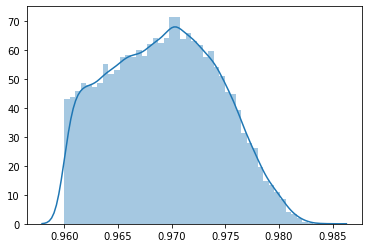

In [38]:
import seaborn as sns
mask = RDM_brain.ravel() >0
a = RDM_brain.ravel()[mask]
sns.distplot(a)
print(len(a))

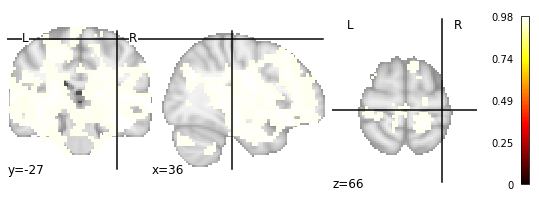

In [35]:
RDM_brain[RDM_brain<0.96] = 0
plot_img = new_img_like(mask_img, RDM_brain)
plotting.plot_stat_map(plot_img, title="",
                       cut_coords=[36, -27, 66])
plt.show()

In [ ]:
# we can also save the upper triangle RDM for each voxel as a nifti
x, y, z = mask.shape
n_conds = len(np.unique(events))
n_comparisons = n_conds * (n_conds-1) // 2
RDM_brain = np.zeros([x*y*z, n_comparisons])
RDM_brain[list(RDM.rdm_descriptors['voxel_index']), :] = RDM.dissimilarities
RDM_brain = RDM_brain.reshape([x, y, z, n_comparisons]